## ARIMA model - AutoRegressive Integrated Moving Average model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Load Hoboken Area Price
df = pd.read_csv('../pre_data/Hoboken_price.csv')

In [3]:
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index)

In [4]:
data.head()

,price
date,
2010-11-01,2534.0
2010-12-01,2553.0
2011-01-01,2553.0
2011-02-01,2539.0
2011-03-01,2525.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2010-11-01 to 2019-01-01
Data columns (total 1 columns):
price    99 non-null float64
dtypes: float64(1)
memory usage: 1.5 KB


In [6]:
# Select the best diff (Integrated)
from statsmodels.tsa.stattools import adfuller as ADF

print(ADF(data['price']))

(-1.8704519883857313, 0.346086508425379, 10, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 588.6211908693606)


In [7]:
diff_1 = data.diff(1)
diff_1 = diff_1.dropna()
diff_1.columns = ['price_integrated']
print(ADF(diff_1['price_integrated']))

(-1.7012039439152993, 0.43049227574251736, 9, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 585.0102940942284)


In [8]:
diff_2 = diff_1.diff(1)
diff_2 = diff_2.dropna()
diff_2.columns = ['price_integrated']
print(ADF(diff_2['price_integrated']))

(-6.156992729182019, 7.327774183151908e-08, 8, 88, {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}, 579.136056583644)


In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

noiseRes = acorr_ljungbox(diff_2, lags=1)
print(noiseRes)

(array([21.7257814]), array([3.14535623e-06]))


In [10]:
# import statsmodels.tsa.stattools as st
# order = st.arma_order_select_ic(data,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
# order.bic_min_order

# from statsmodels.tsa.arima_model import ARMA
# model = ARMA(data, order=order.bic_min_order, freq='MS')
# result_arma = model.fit(disp=-1, method='css')

# pred = result_arma.forecast(steps=6)
# pred

In [11]:
# Select the best AR(p) and MA(q)
from statsmodels.tsa.arima_model import ARMA

def proper_model(data, maxLag): 
    init_bic = float("inf")
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data, order=(p, q), freq='MS')
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_p, init_q

In [12]:
p,q = proper_model(data, 10)

/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInv

In [13]:
print(p,q)

9 2


In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Build ARIMA(9,2,2) model
model = ARIMA(data, (p,2,q), freq='MS')
arima_result = model.fit()

/Users/ryne/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [15]:
arima_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 710.8367  
Dependent Variable: D2.price         Log-Likelihood:      -325.68   
Date:               2019-03-28 15:14 Scale:               1.0000    
No. Observations:   97               Method:              css-mle   
Df Model:           12               Sample:              01-01-2011
Df Residuals:       85                                    01-01-2019
Converged:          1.0000           S.D. of innovations: 6.652     
No. Iterations:     167.0000         HQIC:                690.900   
AIC:                677.3655                                        
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           -0.0736    0.4124   -0.1785  0.8587  -0.8819   0.7347
ar.L1.D2.price   1.5887       nan       nan     nan      nan      nan
ar.L2.D2.price  -1.5431       nan       nan     nan      nan      nan
ar.L3.D2.price   0.0602       nan       nan     nan      nan      nan
ar.L4.D2.price   0.4921    0.0404   12.1746  0.0000   0.4129   0.5713
ar.L5.D2.price  -0.5561    0.0103  -53.7739  0.0000  -0.5763  -0.5358
ar.L6.D2.price  -0.3165    0.0138  -22.9192  0.0000  -0.3435  -0.2894
ar.L7.D2.price   0.3993    0.0301   13.2472  0.0000   0.3402   0.4583
ar.L8.D2.price  -0.2951    0.0576   -5.1258  0.0000  -0.4080  -0.1823
ar.L9.D2.price  -0.1102    0.0292   -3.7706  0.0003  -0.1675  -0.0529
ma.L1.D2.price  -1.2405    0.0595  -20.8626  0.0000  -1.3571  -1.1240
ma.L2.D2.price   1.0000    0.0815   12.2728  0.0000   0.8403   1.1597
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.8863            -0.5891           1.0642            -0.0934
AR.2            0.8863             0.5891           1.0642             0.0934
AR.3            0.6253            -0.7805           1.0001            -0.1425
AR.4            0.6253             0.7805           1.0001             0.1425
AR.5            0.2210            -1.0668           1.0894            -0.2175
AR.6            0.2210             1.0668           1.0894             0.2175
AR.7           -1.2016            -0.6006           1.3433            -0.4262
AR.8           -1.2016             0.6006           1.3433             0.4262
AR.9           -3.7400            -0.0000           3.7400            -0.5000
MA.1            0.6203            -0.7844           1.0000            -0.1435
MA.2            0.6203             0.7844           1.0000             0.1435
====================================================================

"""

In [16]:
# Get forecast 6 steps ahead in future
pred = arima_result.forecast(steps=6)

In [17]:
time = pd.date_range('20190201', periods=6, freq='MS')

In [18]:
pred_df = pd.DataFrame(np.round(pred[0],1), index = time, columns=['price'])

In [19]:
output = pd.concat([data, pred_df], axis=0)

In [20]:
output = output.reset_index()

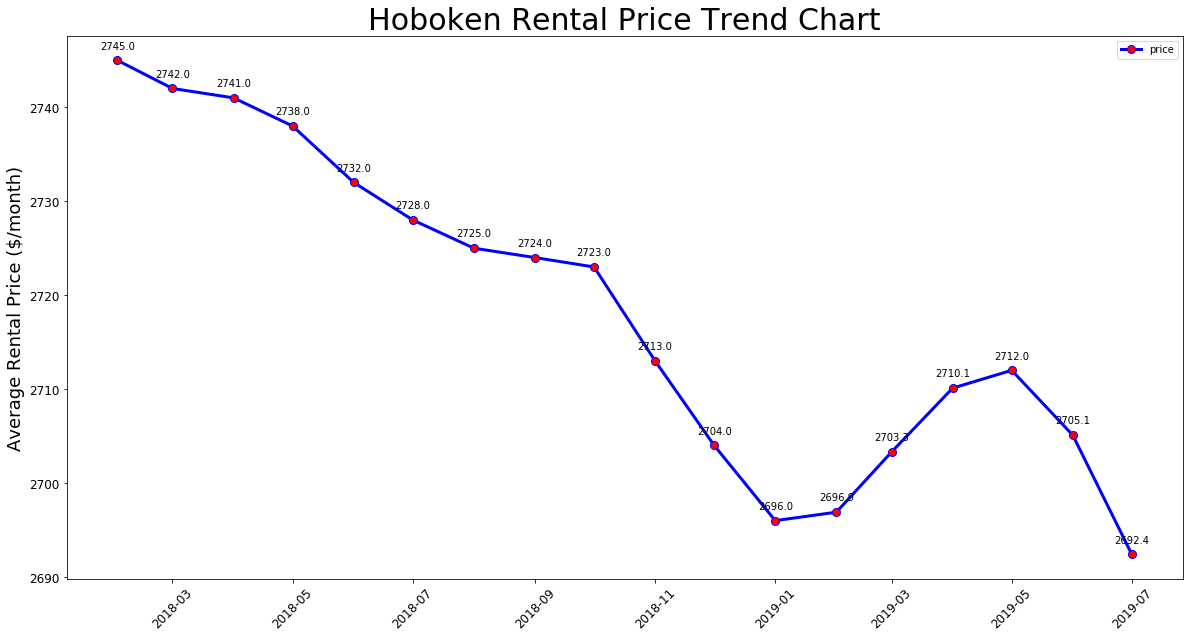

In [21]:
x = output['index'].tail(18)
y = output['price'].tail(18)

plt.figure(figsize = (20, 10))
plt.plot(x, y, linewidth = 3, color='blue', marker = 'o', markerfacecolor='red', markersize=8)

plt.title('Hoboken Rental Price Trend Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 45)
for i, j in zip(x, y):
    plt.text(i, j + 1, j, ha = 'center', va = 'bottom', fontsize = 10)
    
plt.legend()
plt.savefig("../area_predict_pics/Hoboken.jpg")
plt.show()

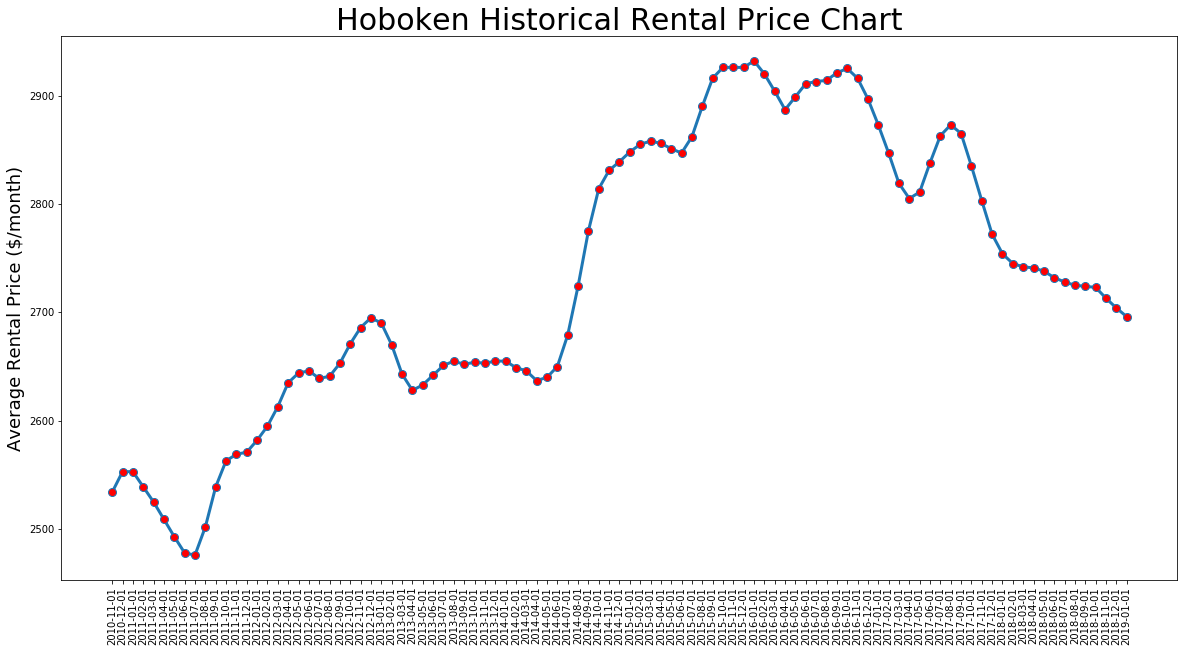

In [23]:
# Check the history data
m = df['date']
n = df['price']
plt.figure(figsize = (20, 10))
plt.plot(m, n, linewidth = 3, marker = 'o', markerfacecolor='red', markersize=8)
plt.title('Hoboken Historical Rental Price Chart', fontsize = 30)
plt.ylabel('Average Rental Price ($/month)', fontsize = 18)
plt.tick_params(labelsize = 12)
plt.xticks(rotation = 90)
# for i, j in zip(m, n):
#     plt.text(i, j + 2, j, ha = 'center', va = 'bottom', fontsize = 10)
plt.show()